In [ ]:
!pip install wand
!apt install imagemagick
!pip install myqlm
!python -m qat.magics.install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.14).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/bin/python3: Error while finding module specification for 'qat.magics.install' (ModuleNotFoundError: No module named 'qat.magics')


## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_z^i \cdot \sigma_z^j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

$$ \langle x | H |x \rangle =\sum_{i,j\in E}{\langle x_i | \sigma_z^i |x_i \rangle \langle x_j | \sigma_z^j |x_j \rangle } = \sum_{i,j\in E} (1-2x_i)  (1-2x_j) $$



In [ ]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:

    #We calculate the average value of H in state x using the properties of vector products given in the pdf file.
    val = 0
    for edge in edges:
      i=edge[0]
      j=edge[1]
      val+=(1-2*b[i])*(1-2*b[j])

    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

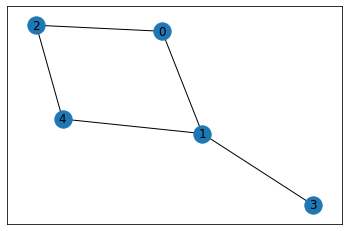

In [ ]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [ ]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [ ]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

$$e^{-i\beta H_c} = e^{-i\beta \sum \sigma_z^i \cdot \sigma_z^j}= \prod_{i,j\in E}e^{-i\beta \sigma_z^i \cdot \sigma_z^j} = \prod_{i,j\in E}U_{ZZ}(2\beta)$$

In [ ]:
def one_qaoa_layer(n_qubits, edges, theta, beta):
    layer = QRoutine()
    #TODO: implement one qaoa layer
    #we apply the x rotation on each qubit
    for qubit in range(n_qubits):
      layer.apply(RX(theta), qubit)
    #we then apply the the cost function hamiltonian using the previous calculation (looping over all edges)
    for edge in edges:
      i = edge[0]
      j = edge[1]
      layer.apply(U_ZZ(2*beta),i,j)
    
    return layer

### Question 4

In [ ]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    #we create an hadamard gate between each qubit
    for qubit_num in range(n_qubits):
      prog.apply(H, qubits[qubit_num])
    
    list_thetas=parameters[::2]
    list_betas=parameters[1::2]

    #we apply each layer of the qaoa
    for parameter_num in range(len(list_thetas)):
      theta=list_thetas[parameter_num]
      beta=list_betas[parameter_num]
      prog.apply(one_qaoa_layer(n_qubits,edges,theta,beta),qubits)

    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
      # this loop is over all 2**nqubits states.
      # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
      b = [int(i)*2-1 for i in sample.state.bitstring] # transforms the 0s into -1s to calculate the observable
      for i,j in edges:
        obs += b[i]*b[j]*sample.probability
    # END TODO
    return obs
    
        

In [ ]:
import numpy as np
np.random.random(3)

array([0.34182044, 0.64276177, 0.40884052])

In [ ]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question: 9 layers seems to be the minimum required to obtain the optimal value for graph 6.

-0.7190174919306476 -1.2024515715487234 -2.220771520309979 -2.5389505752650043 -2.622717525107237 -3.458980231229559 -3.7590251934587844 -4.042373049868073 -4.174866605984626 -4.300355843877002 -4.48412126408999 -4.586267748616452 -4.651379861681671 -4.688503843855768 -4.700477597390018 -4.713036311822046 -4.7180770449746285 -4.726026943137179 -4.738099146276247 -4.750758743764885 -4.7687515741860125 -4.800342796896575 -4.819201886804337 -4.826980041113568 -4.832569310249304 -4.834161096197706 -4.834561085913171 -4.835285600976903 -4.8365882241536875 -4.838760355953781 -4.8416015920187725 -4.843482592079561 -4.846453934185363 -4.850167472874729 -4.850873841118802 -4.851923419306545 -4.852351523759763 -4.852892861298216 -4.853098619925499 -4.853309437679137 -4.8535993007791935 -4.853784610314881 -4.853886454372457 -4.853924907945998 -4.853938205902227 -4.853955273352404 -4.85398615702539 -4.854044243619911 -4.854155349963412 -4.854360857712637 -4.854510998326301 -4.8546507074296406 -4.8

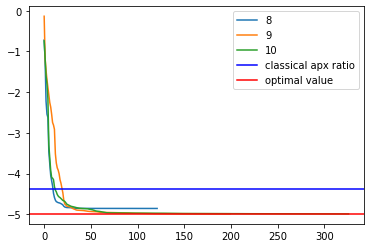

In [ ]:
import matplotlib.pylab as plt


for nlayers in range(8,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

### Question 6: smart initialization

Using the information given in the pdf, we introduce the summ approximation in the exponential and find: 
$$e^{-i∫_0^T H(s)ds}=\prod_{k=1}^p \left[\prod_{l=1}^{n_q} e^{-i \frac{T}{P}(1-\frac{k}{P})\sigma_x^l}\right]\left[e^{-i \frac{kT}{p^2}H_c}\right]$$

Therefore 
$$ \begin{cases}
\theta_k=2\frac{T}{p}(1-\frac{k}{p})\\
\beta_k=\frac{Tk}{p^2}
\end{cases}\,$$

We see that the new implementation significantly speeds up the convergence.

0.6270900144038261 0.28038324827800004 -0.34508436926488484 -0.7805367459348913 -1.3427084653182404 -1.4364372632488147 -1.6000527644112443 -1.8148159480659838 -1.973761951980846 -2.2491643440283906 -2.8008128599432287 -3.1288695973895764 -3.376452313859183 -3.7731112753823095 -3.860669840349649 -3.9561306857594456 -3.965797715301357 -3.9739290855357847 -3.977751985582893 -3.9782482765837326 -3.9782687935086853 -3.978269029213505 -3.9782690296553334 0.33328156101133344 -0.07056468104330738 -0.7441981885014652 -1.6747264224772032 -2.0176916919674817 -2.6963385050289905 -3.3451823826398552 -3.5413731840306393 -3.6145345860386016 -3.6639142936710956 -3.703294007082281 -3.7295930762107465 -3.740648406429719 -3.7435113825451194 -3.7439672444287564 -3.744118439217816 -3.7441213545470275 -3.7441216156212214 -3.7441216166309 -3.7441216166405935 -1.5993592070257328 -2.2878186814030452 -2.719448921835742 -2.9508701977248193 -3.0707793624987216 -3.84239056562277 -3.92618443379188 -4.0802781246350

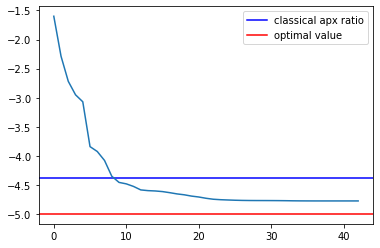

In [ ]:
T = 1.

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    #we implement the creation of the initial parameters expressed earlier
    parameters_init = []
    p=nlayers
    for k in range(p):
      theta_k=((2*T)/p)*(1-k/p)
      beta_k=(T*k)/p
      parameters_init.append(theta_k)
      parameters_init.append(beta_k)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()
plt.plot(back_trace,label=str(nlayers)) #we add this line to plot